# Assumptions

- Equidistanced spatial grid

In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

#### Configure time array

In [2]:
t0 = 0.0
Nt = 201
dt = 0.05

t_arr = t0 + dt*np.arange(Nt)
print("time range: [{}, {}] a.u.".format(*t_arr[[0,-1]]))

time range: [0.0, 10.0] a.u.


#### Configure spatial array

In [3]:
Nx = 101
x_arr = np.linspace(0, 5.1, Nx)
dx = x_arr[1] - x_arr[0]
L = x_arr[-1] - x_arr[0]
print("dx: {}".format(dx))

# Set limit beyond which particles stop
box_xmin, box_xmax = x_arr[0], x_arr[-1]
stop_area_xmin, stop_area_xmax = x_arr[0], x_arr[-1]

dx: 0.051


#### Configure spatial potential energy

In [4]:
Vx = np.zeros_like(x_arr, dtype=float)

#### Configure initial state

In [5]:
wf_x_t0 = np.empty_like(x_arr, dtype=complex)
wf_x_t0[:] = np.sin(pi/L*x_arr) + 0.3*np.sin(2*pi/L*x_arr)
wf_x_t0 /= np.sqrt(np.trapz(np.square(np.abs(wf_x_t0)), x_arr))

#### Configure unit

In [6]:
hbar, m = 1.0, 1.0

#### Configure propagator

In [7]:
from tdse.prop.propagator import Time_Indep_Hamil_Propagator

prop = Time_Indep_Hamil_Propagator(Nx-2, dx, Vx[1:-1], m=1.0)

#### Configure particles

In [8]:
xp_t0_arr = np.linspace(x_arr[2], x_arr[-3], 11)

# Propagate

In [9]:
from warnings import filterwarnings
filterwarnings('error')

# [TODO] Install fresh `scipy` package and fix only the relavent part, as minimal as possible but enough for this script to be run correctly. Control the version with `git`. Consider suggesting the modification to `scipy` society.

- [ ] evalution flow of iteration termination condition in `scipy.optimize.nonlin.TerminationCondition`
- [ ] applying limits on nonlinear solve during determination of `dx` in `scipy.optimize.nonlin.nonlin_solve()`

In [10]:
def g_func(_dxp, _xp, _x_arr, _dx, _wf_arr, _dt, _A, _b, 
            _hbar, _m, _Ns, _lowers, _uppers, rfac=1e-3, _vv=False):

    # Determine `_is0` 
    # : the first index of stencils for finite-difference method
    _x = _xp + _dxp
    _il = int((_x-_x_arr[0])//_dx)  # index of nearest-left x_arr point
    _Nx = _x_arr.size
    assert _Ns == 4  # formula for _is0 here is valid for `_Ns==4`
    _is0 = _il - 1 + (1>_il)*(1-_il) + (Nx-3<_il)*((Nx-3)-_il)

    # Solve to get wf and its derivatives at `_x`
    _xi_minus_x = (_x_arr[_is0:_is0+_Ns] - _x)
    _A[:,0] = 1.
    for _i in range(1,_Ns): 
        _A[:,_i] = _A[:,_i-1] * _xi_minus_x / _i
    _b[:] = _wf_arr[_is0:_is0+_Ns]

    try: _wf, _dx_wf, _dx2_wf, _dx2_wf = np.linalg.solve(_A, _b)
    except np.linalg.LinAlgError as e:
        raise RuntimeError("Failed to get wf at given x: {}".format(_x))
    except: raise Exception("Unexpected error")

    if _wf == 0: raise NotImplementedError

    # Evaluate Bohmian velocity field value
    _v = _hbar / _m * np.imag(_dx_wf / _wf)

    # Evaluate and return objective function value `_g`
    _g = -_dxp + _dt * _v

    return _g

In [11]:
# Initialize
xp_arr = np.empty_like(xp_t0_arr)
xp_arr[:] = xp_t0_arr
xp_arr_t = np.zeros((Nt, xp_arr.size))
xp_arr_t[0,:] = xp_arr

wf_x = np.empty_like(wf_x_t0)
wf_x[:] = wf_x_t0
wf_x_t = np.zeros((Nt,wf_x.size), dtype=wf_x.dtype)
wf_x_t[0,:] = wf_x


# Arrays for Finite Difference method
Ns = 4
A = np.empty((Ns,Ns), dtype=float)
b = np.empty((Ns,), dtype=complex)

# Check whether the spatial array has equal spacings
assert np.std(np.diff(x_arr)) < 1e-8 * np.mean(x_arr)

# For debug
g_args = None
dxp_g_list = []
def callback(dxp,g): 
    dxp_g_list.append((dxp[0],g[0]))
    print("[callback][dxp={:.16f}, g={:.16f}]".format(dxp[0],g[0]), end='\n\n')

    
# iteration over time
from scipy.optimize import root
for it in range(Nt):

    prop.propagate(wf_x[1:-1], dt, Nt=1)
    
    for ip, xp in enumerate(xp_arr):
        
        if not (stop_area_xmin < xp and xp < stop_area_xmax): continue

        _g_args = (xp, x_arr, dx, wf_x, dt, A, b, 
                   hbar, m, Ns, box_xmin-xp, box_xmax-xp, 1e-3)
            
        _opt_broyden1 = {'xtol':1e0, 'nit':200, 
                         'lowers':box_xmin-xp, 'uppers':box_xmax-xp}
        _tot_opt = {'method':'broyden1', 'options': _opt_broyden1}
        
        _dxp0 = 0.0
        _failed = False
        try: _sol = root(g_func, _dxp0, _g_args, **_tot_opt)
        except Exception as e: _failed = True

        if _failed or not _sol.success:
            g_args = _g_args
            dxp_g_list = []
            _g_args_at_err = _g_args + (True,)
            _tot_opt_at_err = { 'method':_tot_opt['method'], 'callback': callback, 
                               'options': {**_opt_broyden1, 'disp':True}}
            try: _sol = root(g_func, _dxp0, _g_args_at_err, **_tot_opt_at_err)
            except Exception as e: print(e)
            _msg = ("Failed for time-index={}, "
                    "particle-position==xp_arr[{}]={:.4f}\n"
                    "opt_result:\n{}")
            raise Exception(_msg.format(it, ip, xp, _sol if not _failed else None))
            
        _dxp = _sol.x
        xp_arr[ip] += _dxp
        
        
        # Store
        xp_arr_t[it,:] = xp_arr
        wf_x_t[it,:] = wf_x

#### Visualize

In [12]:
pdf_x_t = np.square(np.abs(wf_x_t))

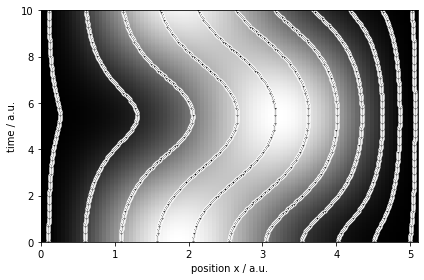

In [13]:
figsize=(12,6)
fig, ax = plt.subplots()

from vis.plot import construct_catesian_mesh_for_pcolormesh
x_cmesh, t_cmesh = construct_catesian_mesh_for_pcolormesh(x_arr, t_arr)
ax.pcolormesh(x_cmesh, t_cmesh, pdf_x_t.transpose(), cmap='gray')

for ip in range(xp_t0_arr.size):
    ax.plot(xp_arr_t[:,ip], t_arr, '.', color='white', mfc='black')
    
ax.set_xlim(*x_arr[[0,-1]]), ax.set_ylim(*t_arr[[0,-1]])

ax.set_xlabel("position x / a.u."), ax.set_ylabel("time / a.u.")
fig.tight_layout()

# fig.savefig("particles-dx-{:.4f}-test-16.png".format(dx))

# [CAUTION] When using `broyden1` method, set `xtol` (relative tolerance on x) in order to prevent `RuntimeWarning`

# ETC>

In [112]:
# Arrays for Finite Difference method
Ns = 4
A = np.empty((Ns,Ns), dtype=float)
A[:,0] = 1.
b = np.empty((Ns,), dtype=complex)


def ff(_x):
    Ns = 4
    _x_arr=x_arr
    _wf_arr = wf_x
    _A = A
    _b = b
    
    _dx = _x_arr[1] - _x_arr[0]

    _is0 = int((_x-_x_arr[0])//_dx)
    _Nx = _wf_arr.size
    if _is0 > _Nx//2: _is0 += -2
    _xi_minus_x = (_x_arr[_is0:_is0+Ns] - _x)
    _A[:,1] = _A[:,0] * _xi_minus_x / 1.
    _A[:,2] = _A[:,1] * _xi_minus_x / 2.
    _A[:,3] = _A[:,2] * _xi_minus_x / 3.
    _b[:] = _wf_arr[_is0:_is0+Ns]

    try: _wf, _dx_wf, _dx2_wf, _dx3_wf = np.linalg.solve(_A, _b)
    except np.linalg.LinAlgError as e:
        raise RuntimeError("Failed to get wf at given x: {}".format(_x))
    except: raise Exception("Unexpected error")

    if _wf == 0: raise NotImplementedError
    _v = np.imag(_dx_wf / _wf)
    _dx_v = np.imag( (_dx2_wf/_wf) - (_dx_wf/_wf)**2 )
    _dx_v1 = np.imag((_dx2_wf/_wf))
    _dx_v2 = -np.imag((_dx_wf/_wf)**2)
    _dx_wf_over_wf = _dx_wf / _wf
    _dx2_wf_over_wf = _dx2_wf / _wf
    return _wf, _dx_wf, _dx2_wf, _dx3_wf, _v, _dx_v, _dx_v1, _dx_v2, _dx_wf_over_wf, _dx2_wf_over_wf

In [115]:
# xxx = xp+np.linspace(-0.000005, 0.00001, 201)
xxx = x_arr[-2] + np.linspace(-0.0005, 0.0005, 201)
wf_dx_dx2 = np.array([ff(x) for x in xxx])

# [TODO] Use of 4-stencils seems to be required for 'continuous v', not just continous wf.

# [TODO] why are the jacobian of v, i.e. dx_v discontinous?

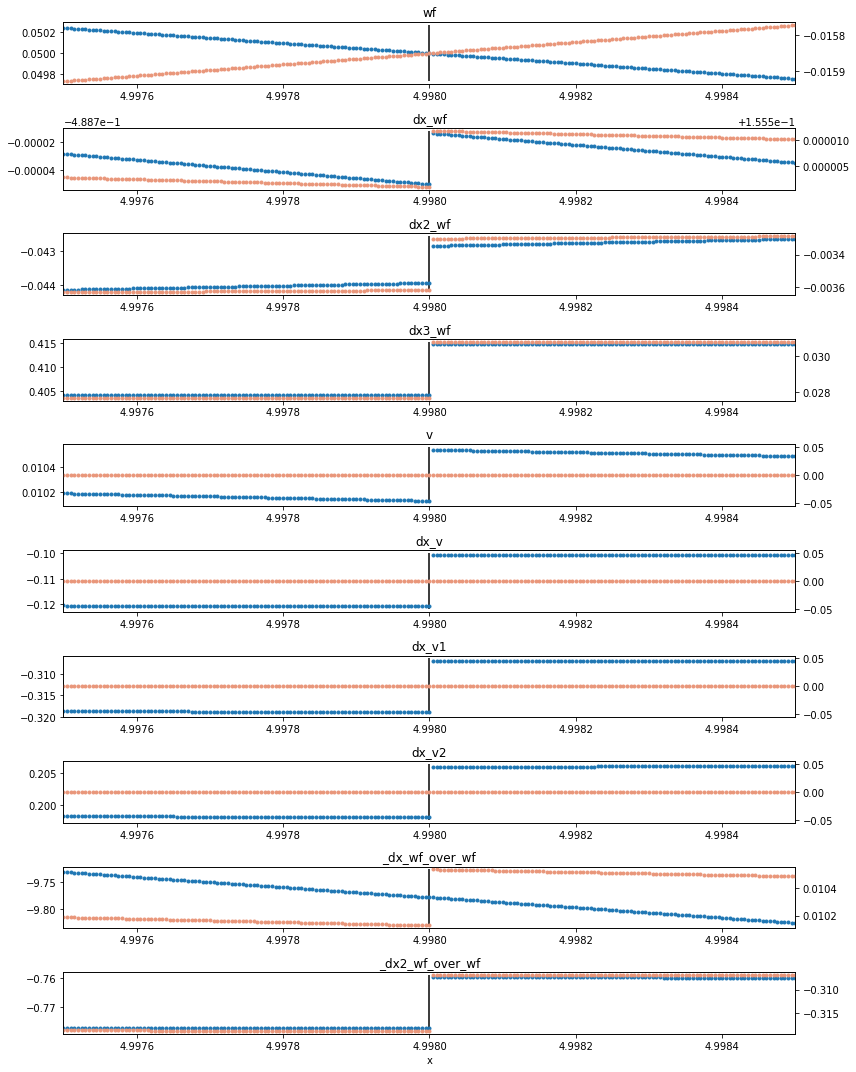

In [116]:
ax_titles = ('wf', 'dx_wf', 'dx2_wf', 'dx3_wf', 'v', 'dx_v', 'dx_v1', 'dx_v2', '_dx_wf_over_wf', '_dx2_wf_over_wf')

fig, axes = plt.subplots(nrows=len(ax_titles), figsize=(12,15))

for i, ax in enumerate(axes):
    ax.set_xlim(xxx[[0,-1]])
    ax.plot(xxx, wf_dx_dx2[:,i].real, '.')
#     if ax_titles[i] in ('_dx_wf_over_wf',):
    ax2 = ax.twinx()
    ax2.plot(xxx, wf_dx_dx2[:,i].imag, '.',color='darksalmon')
    
    ax.vlines(x_arr, *ax.get_ylim())
    ax.set_title(ax_titles[i])
axes[-1].set_xlabel("x")
fig.tight_layout()
# fig.savefig("discreteness-fd-4-stencil-test-9.png")

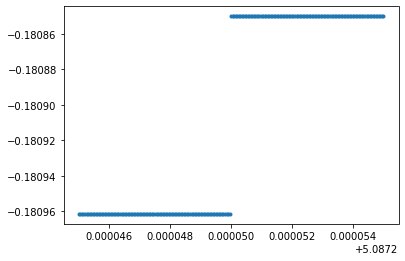

In [17]:
fig, ax = plt.subplots()
ax.plot(xxx, (wf_dx_dx2[:,-1]).imag, '.')

# ETC>

In [121]:
g_func(0.0, *g_args)

0.003862201594893755

In [122]:
dxp_g_arr = np.asarray(dxp_g_list)
dxp_g_arr

array([[ 1.55318792e-05,  3.84686524e-03],
       [ 3.91144067e-03, -3.31150321e-05],
       [ 3.87818970e-03,  3.28002723e-05],
       [ 3.89473579e-03,  1.64621924e-05],
       [ 3.89679991e-03,  1.44240288e-05],
       [ 3.89818836e-03,  1.30530341e-05],
       [ 3.89921733e-03,  1.20369950e-05],
       [ 3.90002424e-03,  1.12402299e-05],
       [ 3.90003008e-03,  1.12344679e-05],
       [ 3.90003589e-03,  1.12287311e-05],
       [ 3.90004167e-03,  1.12230192e-05],
       [ 3.90004743e-03,  1.12173321e-05],
       [ 3.90005317e-03,  1.12116695e-05],
       [ 3.90005888e-03,  1.12060313e-05],
       [ 3.90006456e-03,  1.12004172e-05],
       [ 3.90007022e-03,  1.11948271e-05],
       [ 3.90007586e-03,  1.11892608e-05],
       [ 3.90008148e-03,  1.11837179e-05],
       [ 3.90008707e-03,  1.11781985e-05],
       [ 3.90009263e-03,  1.11727022e-05],
       [ 3.90009817e-03,  1.11672289e-05],
       [ 3.90010369e-03,  1.11617785e-05],
       [ 3.90010919e-03,  1.11563506e-05],
       [ 3.

In [123]:
if dxp_g_arr.size > 0:
    np.average(dxp_g_arr[:,1])

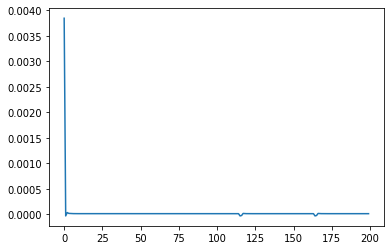

In [124]:
fig, ax = plt.subplots()
ax.plot(dxp_g_arr[:,1])
# ax2 = ax.twinx()
# ax2.plot(np.diff(dxp_g_arr[:,1]), color='darksalmon')
# ax.set_ylim(-0.00005, 0.00005)

In [125]:
xp = g_args[0]
x_minus_xp_arr = x_arr - xp

In [126]:
dxp_g_median = np.median(dxp_g_arr[:,0])
dxp_arr = np.linspace(dxp_g_median-0.0001,dxp_g_median+0.0001,101)
g_arr = np.asarray([g_func(dxp, *g_args) for dxp in dxp_arr])

In [127]:
box_xmax - xp

4.797900516351801

In [128]:
g_func(0.0, *g_args)

0.003862201594893755

In [129]:
xp = g_args[0]
x_minus_xp_arr = x_arr - xp

In [132]:
dxp_macrosco_arr = np.linspace(-0.01, 0.02, 101)
g_macrosco_arr = np.asarray([g_func(dxp, *g_args) for dxp in dxp_macrosco_arr])

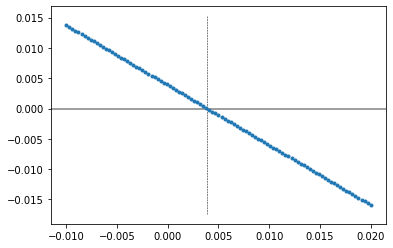

In [134]:
fig, ax = plt.subplots()
ax.plot(dxp_macrosco_arr, g_macrosco_arr, '.')
ax.set_xlim(*ax.get_xlim())
ax.vlines(x_minus_xp_arr, *ax.get_ylim(), linestyle='--', linewidth=0.5)
ax.hlines(0, *ax.get_xlim(), color='gray')
# fig.savefig("discontinous-probably-due-to-malicious-extended-func-test-1.png")

In [117]:
g_func(0.0, *g_args)

0.003862201594893755

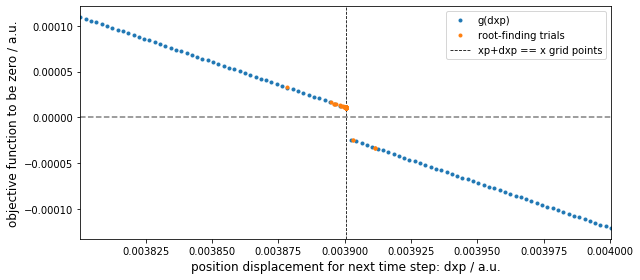

In [136]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(dxp_arr, g_arr, '.', label='g(dxp)')
ax.set_ylim(*ax.get_ylim())
ax.set_xlim(*dxp_arr[[0,-1]])

ax.vlines(x_minus_xp_arr, *ax.get_ylim(), linestyle='--', linewidth=0.8, label='xp+dxp == x grid points')

ax.plot(dxp_arr[[0,-1]], [0,0], '--', color='gray')
if dxp_g_arr.size > 0:
    ax.plot(dxp_g_arr[:,0], dxp_g_arr[:,1], '.', label='root-finding trials')
    
ax.legend()
ax.set_xlabel("position displacement for next time step: dxp / a.u.", fontsize='large')
ax.set_ylabel("objective function to be zero / a.u.", fontsize='large')
fig.tight_layout()
# fig.savefig("discontinuous-nature-of-obj-func-to-be-zero-test-4.png")

# [..may be not][TODO] Let's just use jacobian instead of approximation, since it isn't too hard to evaluate

#### Animate propagation

In [ ]:
# %matplotlib notebook

# from matplotlib.animation import FuncAnimation

In [ ]:
# fig, ax = plt.subplots()

# l_real, = ax.plot([],[])
# l_abs, = ax.plot([],[])
# ax.set_xlim(*x_arr[[0,-1]]), ax.set_ylim(-1,1)
# text = ax.text(0,0,'')

# def init(): 
#     wf_x[:] = wf_x_t0
#     l_real.set_data(x_arr, wf_x.real)
#     l_abs.set_data(x_arr, np.abs(wf_x))
#     return l_real, l_abs
    
# def update(i):
#     prop.propagate(wf_x[1:-1], dt, Nt=10)
#     l_real.set_data(x_arr, wf_x.real)
#     l_abs.set_data(x_arr, np.abs(wf_x))
#     text.set_text(i)

# ani = FuncAnimation(fig, update, frames=15, init_func=init)